# Importing Libraries

In [1]:
from numpy.random import seed
seed(101)
import tensorflow as tf
tf.random.set_seed(101)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Flatten

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil


# Import Data

In [2]:
os.listdir('D:/Bangkit/Capstone')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'ISIC2018_Task3_Validation_GroundTruth',
 'ISIC2018_Task3_Validation_Input',
 'model.h5',
 'model.keras',
 'requirements.txt',
 'Skinlyze-ML-Notebook (1).ipynb',
 'Skinlyze-ML-Notebook.ipynb']

### Create the directory structure

In [3]:
# Create a new directory
base_dir = 'base_dir'
os.makedirs(base_dir, exist_ok=True)

# now create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
 
# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.makedirs(train_dir, exist_ok=True)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.makedirs(val_dir, exist_ok=True)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.makedirs(nv, exist_ok=True)
mel = os.path.join(train_dir, 'mel')
os.makedirs(mel, exist_ok=True)
bkl = os.path.join(train_dir, 'bkl')
os.makedirs(bkl, exist_ok=True)
bcc = os.path.join(train_dir, 'bcc')
os.makedirs(bcc, exist_ok=True)
akiec = os.path.join(train_dir, 'akiec')
os.makedirs(akiec, exist_ok=True)
vasc = os.path.join(train_dir, 'vasc')
os.makedirs(vasc, exist_ok=True)
df = os.path.join(train_dir, 'df')
os.makedirs(df, exist_ok=True)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.makedirs(nv, exist_ok=True)
mel = os.path.join(val_dir, 'mel')
os.makedirs(mel, exist_ok=True)
bkl = os.path.join(val_dir, 'bkl')
os.makedirs(bkl, exist_ok=True)
bcc = os.path.join(val_dir, 'bcc')
os.makedirs(bcc, exist_ok=True)
akiec = os.path.join(val_dir, 'akiec')
os.makedirs(akiec, exist_ok=True)
vasc = os.path.join(val_dir, 'vasc')
os.makedirs(vasc, exist_ok=True)
df = os.path.join(val_dir, 'df')
os.makedirs(df, exist_ok=True)

### Create Train and Val Sets

In [4]:
df_data = pd.read_csv('D:/Bangkit/Capstone/HAM10000_metadata.csv')
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Create a stratified val set

In [5]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


# Exploratory Data Analysis (EDA)

In [6]:
def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [7]:
df_data['duplicates'].value_counts()

duplicates
no_duplicates     5514
has_duplicates    4501
Name: count, dtype: int64

In [8]:
df = df_data[df_data['duplicates'] == 'no_duplicates']
df.shape

(5514, 8)

In [9]:
y = df['dx']

_, df_val = train_test_split(df, test_size=0.15, random_state=101, stratify=y)

df_val.shape

(828, 8)

In [10]:
df_val['dx'].value_counts()

dx
nv       663
bkl       66
mel       34
bcc       26
akiec     23
vasc      10
df         6
Name: count, dtype: int64

Text(0.5, 1.0, 'Frequency Distribution of Classes')

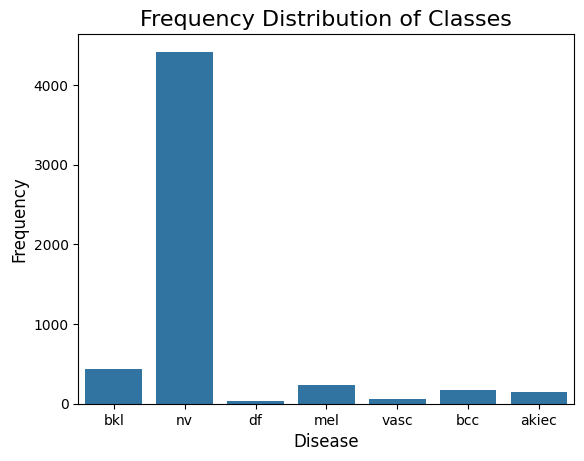

In [11]:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

Text(0.5, 1.0, 'Frequency Distribution of Classes')

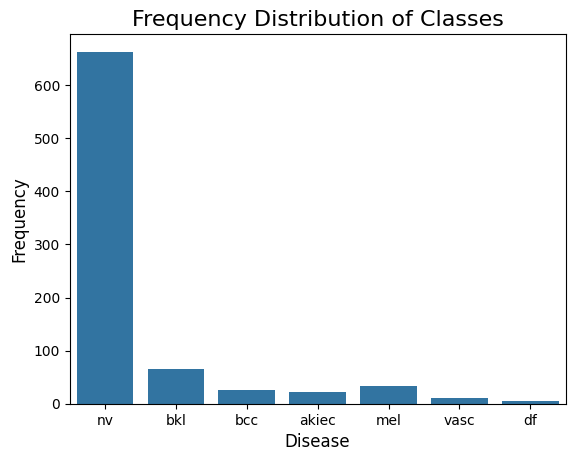

In [12]:
sns.countplot(x = 'dx', data = df_val)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

### Create a train set that excludes images that are in the val set

In [13]:
def identify_val_rows(x):
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

df_data['train_or_val'] = df_data['image_id']
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))


9187
828


In [14]:
df_train['dx'].value_counts()

dx
nv       6042
mel      1079
bkl      1033
bcc       488
akiec     304
vasc      132
df        109
Name: count, dtype: int64

In [15]:
df_val['dx'].value_counts()

dx
nv       663
bkl       66
mel       34
bcc       26
akiec     23
vasc      10
df         6
Name: count, dtype: int64

### Transfer the Images into the Folders

In [16]:
df_data.set_index('image_id', inplace=True)

In [17]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('D:/Bangkit/Capstone/HAM10000_images_part_1')
folder_2 = os.listdir('D:/Bangkit/Capstone/HAM10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('D:/Bangkit/Capstone/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('D:/Bangkit/Capstone/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('D:/Bangkit/Capstone/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('D:/Bangkit/Capstone/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        

In [18]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

6042
1079
1033
488
304
132
109


In [19]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

663
34
66
26
23
10
6


In [20]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1079 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 304 images belonging to 1 classes.
Found 132 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [21]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

6042
5945
5965
5906
5268
5330
4410


In [22]:
original_images_count = {
    'mel': len(os.listdir('base_dir/train_dir/mel')),
    'bkl': len(os.listdir('base_dir/train_dir/bkl')),
    'bcc': len(os.listdir('base_dir/train_dir/bcc')),
    'akiec': len(os.listdir('base_dir/train_dir/akiec')),
    'vasc': len(os.listdir('base_dir/train_dir/vasc')),
    'df': len(os.listdir('base_dir/train_dir/df')),
    'nv': len(os.listdir('base_dir/train_dir/nv'))  # No augmentation for 'nv'
}

print("Original and augmented image counts per class:")
for key, value in original_images_count.items():
    print(f"{key}: {value} images")


Original and augmented image counts per class:
mel: 5945 images
bkl: 5965 images
bcc: 5906 images
akiec: 5268 images
vasc: 5330 images
df: 4410 images
nv: 6042 images


### Visualize 50 augmented images


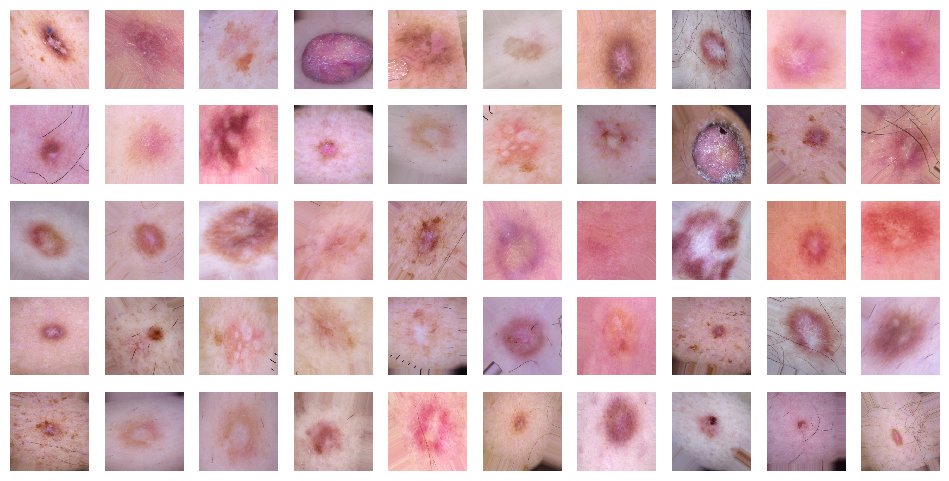

In [23]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None)

### Set Up the Generators

In [24]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 64
val_batch_size = 16
image_size = 224

train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))


In [25]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38866 images belonging to 7 classes.
Found 828 images belonging to 7 classes.
Found 828 images belonging to 7 classes.


### Modify MobileNet Model

In [26]:
mobile = tensorflow.keras.applications.MobileNetV2()

In [27]:
mobile.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [28]:
type(mobile.layers)

list

In [29]:
len(mobile.layers)


156

In [30]:
x = mobile.layers[-6].output
x = Flatten()(x)
predictions = Dense(7, activation='softmax')(x)


model = Model(inputs=mobile.input, outputs=predictions)

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 1,953,031 (7.45 MB)

 Trainable params: 1,921,479 (7.33 MB)

 Non-trainable params: 31,552 (123.25 KB)

In [32]:
for layer in model.layers[:-23]:
    layer.trainable = False

### Train the Model

In [33]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [34]:
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [35]:
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [36]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 1.0, # mel 
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [37]:
# Check the shapes of data returned by the generator
image_batch, label_batch = next(iter(train_batches))
print(image_batch.shape)  # Expected: (batch_size, height, width, channels)
print(label_batch.shape)  # Expected: (batch_size, num_classes)


(64, 224, 224, 3)
(64, 7)


In [38]:
filepath = "model.keras"

checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
callbacks_list = [checkpoint, reduce_lr]



In [39]:
def generator_to_dataset(generator):
    return tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),  # Adjust data types if needed
        output_shapes=([None, 224, 224, 3], [None, 7])  # Adjust to match image and label shapes
    )

train_dataset = generator_to_dataset(train_batches)
valid_dataset = generator_to_dataset(valid_batches)

# Prefetch for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [40]:
history = model.fit(
    train_batches,
    steps_per_epoch=train_steps,
    validation_data=valid_batches,
    validation_steps=val_steps,
    epochs=15,
    verbose=1,
    callbacks=callbacks_list
)


C:\Users\rafid\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - categorical_accuracy: 0.5443 - loss: 3.2967 - top_2_accuracy: 0.7278 - top_3_accuracy: 0.8478 - val_categorical_accuracy: 0.8164 - val_loss: 4.4285 - val_top_2_accuracy: 0.9155 - val_top_3_accuracy: 0.9650 - learning_rate: 0.0010
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - categorical_accuracy: 0.7120 - loss: 1.0133 - top_2_accuracy: 0.8756 - top_3_accuracy: 0.9528 - val_categorical_accuracy: 0.0507 - val_loss: 196.4482 - val_top_2_accuracy: 0.6739 - val_top_3_accuracy: 0.8031 - learning_rate: 0.0010
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7727 - loss: 0.6390 - top_2_accuracy: 0.9154 - top_3_accuracy: 0.9676
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
144/144 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - categorical_accuracy: 0.7728 - loss: 0.6389 - top_2_accuracy: 0.9154 - top_3_accuracy: 0.9676 - val_categorical_accuracy: 0.3357 - val_loss: 36.3156 - val_top_2_

C:\Users\rafid\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
144/144 ━━━━━━━━━━━━━━━━━━━━ 65s 447ms/step - categorical_accuracy: 0.8588 - loss: 0.4035 - top_2_accuracy: 0.9597 - top_3_accuracy: 0.9908 - val_categorical_accuracy: 0.2283 - val_loss: 11.8635 - val_top_2_accuracy: 0.4807 - val_top_3_accuracy: 0.6896 - learning_rate: 5.0000e-04
Epoch 6/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - categorical_accuracy: 0.8658 - loss: 0.3631 - top_2_accuracy: 0.9642 - top_3_accuracy: 0.9912 - val_categorical_accuracy: 0.4372 - val_loss: 4.2716 - val_top_2_accuracy: 0.6848 - val_top_3_accuracy: 0.8056 - learning_rate: 2.5000e-04
Epoch 7/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9004 - loss: 0.2794 - top_2_accuracy: 0.9762 - top_3_accuracy: 0.9956
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
144/144 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - categorical_accuracy: 0.9004 - loss: 0.2795 - top_2_accuracy: 0.9762 - top_3_accuracy:

### Evaluate the model using the val set

In [41]:
model.metrics_names

['loss', 'compile_metrics']

In [42]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

828/828 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - categorical_accuracy: 0.7470 - loss: 0.8845 - top_2_accuracy: 0.8912 - top_3_accuracy: 0.9487
val_loss: 0.45901596546173096
val_cat_acc: 0.8611111044883728
val_top_2_acc: 0.9432367086410522
val_top_3_acc: 0.979468584060669


In [43]:
model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

828/828 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - categorical_accuracy: 0.2506 - loss: 2.5154 - top_2_accuracy: 0.4949 - top_3_accuracy: 0.6410
val_loss: 2.2662534713745117
val_cat_acc: 0.2753623127937317
val_top_2_acc: 0.5471014380455017
val_top_3_acc: 0.7125604152679443


### Plot the Training Curves

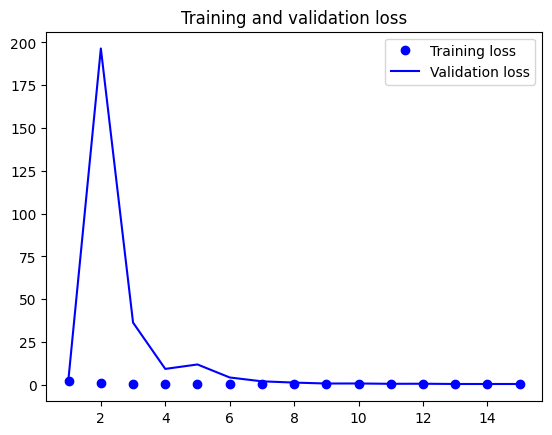

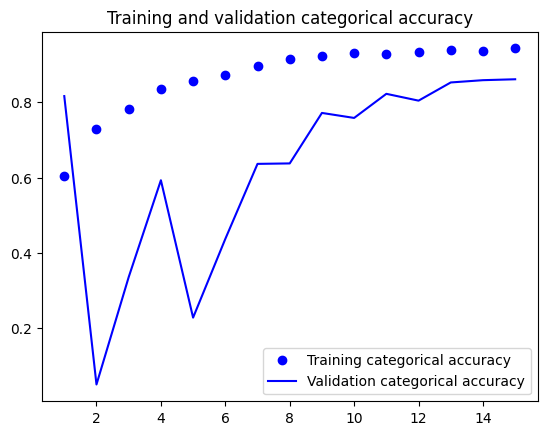

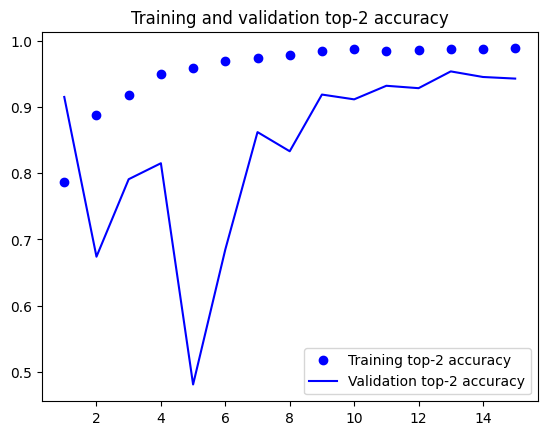

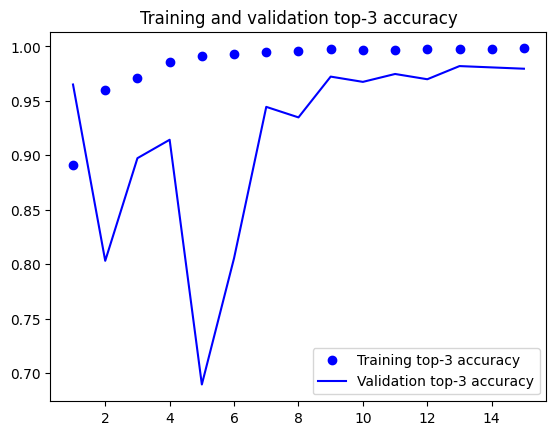

In [44]:
import matplotlib.pyplot as plt

# Get the lengths of training and validation metrics
train_epochs = len(history.history['categorical_accuracy'])
val_epochs = len(history.history['val_categorical_accuracy'])

# Determine the minimum length to avoid mismatched dimensions
epochs = min(train_epochs, val_epochs)

# Trim the lists to the same length
acc = history.history['categorical_accuracy'][:epochs]
val_acc = history.history['val_categorical_accuracy'][:epochs]
loss = history.history['loss'][:epochs]
val_loss = history.history['val_loss'][:epochs]
train_top2_acc = history.history['top_2_accuracy'][:epochs]
val_top2_acc = history.history['val_top_2_accuracy'][:epochs]
train_top3_acc = history.history['top_3_accuracy'][:epochs]
val_top3_acc = history.history['val_top_3_accuracy'][:epochs]

# Plot training and validation loss
plt.plot(range(1, epochs + 1), loss, 'bo', label='Training loss')
plt.plot(range(1, epochs + 1), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

# Plot training and validation categorical accuracy
plt.plot(range(1, epochs + 1), acc, 'bo', label='Training categorical accuracy')
plt.plot(range(1, epochs + 1), val_acc, 'b', label='Validation categorical accuracy')
plt.title('Training and validation categorical accuracy')
plt.legend()
plt.figure()

# Plot training and validation top-2 accuracy
plt.plot(range(1, epochs + 1), train_top2_acc, 'bo', label='Training top-2 accuracy')
plt.plot(range(1, epochs + 1), val_top2_acc, 'b', label='Validation top-2 accuracy')
plt.title('Training and validation top-2 accuracy')
plt.legend()
plt.figure()

# Plot training and validation top-3 accuracy
plt.plot(range(1, epochs + 1), train_top3_acc, 'bo', label='Training top-3 accuracy')
plt.plot(range(1, epochs + 1), val_top3_acc, 'b', label='Validation top-3 accuracy')
plt.title('Training and validation top-3 accuracy')
plt.legend()

plt.show()


### Create a Confusion Matrix

In [45]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [46]:
test_batches.class_indices


{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [47]:
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)

828/828 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step


In [48]:
predictions.shape

(828, 7)

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

test_labels.shape


(828,)

In [50]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  7   3   1   0   1   3   8]
 [  9   9   1   0   1   0   6]
 [ 20  17   2   4   1  10  12]
 [  0   2   1   0   0   3   0]
 [  8   5   2   1   5   4   9]
 [ 92 233  68  12   5 204  49]
 [  3   2   1   0   0   3   1]]


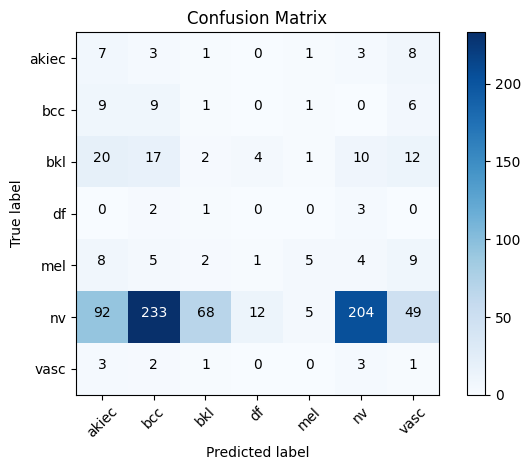

In [51]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [52]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_batches.classes

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.05      0.30      0.09        23
         bcc       0.03      0.35      0.06        26
         bkl       0.03      0.03      0.03        66
          df       0.00      0.00      0.00         6
         mel       0.38      0.15      0.21        34
          nv       0.90      0.31      0.46       663
        vasc       0.01      0.10      0.02        10

    accuracy                           0.28       828
   macro avg       0.20      0.18      0.12       828
weighted avg       0.74      0.28      0.38       828



### Save File Format h5

In [53]:
model.save("model.h5", save_format="h5")